## Prognosix


### Introduction

Chronic Kidney Disease (CKD) is when the kidneys are destroyed over time and do not have full functionality. CKD is known as a silent killer that often goes undiagnosed until its late stages. 

Prognosix goal is to develop a diagnostic tool that can predict the likelihood of CKD by using the [UCI ML Repository dataset](https://archive.ics.uci.edu/dataset/336/chronic+kidney+disease). By analyzing biomarkers and clinical data collected from patients such as their blood pressure, hemoglobin, age, and albumin measurements, we can see patterns and correlations that can be used to classify individuals at-risk for CKD. We aim to support healthcare providers in making a diagnosis which allows for timely interventions and a reduction in complications. 

### Exploratory Data Analysis
Cindy Rocha

In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve,
                             RocCurveDisplay, ConfusionMatrixDisplay, classification_report)
import shap

We tried downloading the data from the UCI ML Repository, but the .arff file with the data had several issues. However, someone had already converted this data into .csv in Kaggle.
I decided to use the kaggle data due to convenience. I also did check for any discrepencies.

[Stack Overflow post](https://stackoverflow.com/questions/62653514/open-an-arff-file-with-scipy-io/66939746#66939746)

In [2]:
df = pd.read_csv("chronic_kidney_disease.csv")

# dropping the redundant id feature
df = df.drop('id', axis=1)

df

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35,7300,4.6,no,no,no,good,no,no,ckd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,140.0,...,47,6700,4.9,no,no,no,good,no,no,notckd
396,42.0,70.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,75.0,...,54,7800,6.2,no,no,no,good,no,no,notckd
397,12.0,80.0,1.020,0.0,0.0,normal,normal,notpresent,notpresent,100.0,...,49,6600,5.4,no,no,no,good,no,no,notckd
398,17.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,114.0,...,51,7200,5.9,no,no,no,good,no,no,notckd


In [3]:
df.shape

(400, 25)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             330 non-null    object 
 16  wc              295 non-null    object 
 17  rc              270 non-null    obj

In [5]:
# pcv, wc, and rc are actually numerical. 
df['pcv'] = pd.to_numeric(df['pcv'], errors='coerce')
df['wc'] = pd.to_numeric(df['wc'], errors='coerce')
df['rc'] = pd.to_numeric(df['rc'], errors='coerce')

# sg, al, su are categorical
categorical_cols = ['sg', 'al', 'su']
df[categorical_cols] = df[categorical_cols].astype('object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    object 
 3   al              354 non-null    object 
 4   su              351 non-null    object 
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             329 non-null    float64
 16  wc              294 non-null    float64
 17  rc              269 non-null    flo

In [7]:
# Checking for duplicated data
df.duplicated().sum()

0

In [8]:
# unique values per feature
df.nunique()

age                76
bp                 10
sg                  5
al                  6
su                  6
rbc                 2
pc                  2
pcc                 2
ba                  2
bgr               146
bu                118
sc                 84
sod                34
pot                40
hemo              115
pcv                42
wc                 89
rc                 45
htn                 2
dm                  3
cad                 2
appet               2
pe                  2
ane                 2
classification      2
dtype: int64

I noticed that data that should only have 2 unique values has more than 2 such as cad, classification, and dm. Upon further inspection in the .csv file, there are trailing spaces in some rows. So, below I remove those spaces:

In [9]:
df = df.apply(lambda x: x.strip() if isinstance(x, str) else x)

In [10]:
df.nunique()

age                76
bp                 10
sg                  5
al                  6
su                  6
rbc                 2
pc                  2
pcc                 2
ba                  2
bgr               146
bu                118
sc                 84
sod                34
pot                40
hemo              115
pcv                42
wc                 89
rc                 45
htn                 2
dm                  3
cad                 2
appet               2
pe                  2
ane                 2
classification      2
dtype: int64

Below shows how many values are missing per column. I noticed that a lot of rows were missing information about red blood cells (rbc), red blood cell count (rc), and white blood cell count (wc)...

In [11]:
# Percentage of missing data/rows per feature
df.isnull().sum() / df.shape[0] * 100

age                2.25
bp                 3.00
sg                11.75
al                11.50
su                12.25
rbc               38.00
pc                16.25
pcc                1.00
ba                 1.00
bgr               11.00
bu                 4.75
sc                 4.25
sod               21.75
pot               22.00
hemo              13.00
pcv               17.75
wc                26.50
rc                32.75
htn                0.50
dm                 0.50
cad                0.50
appet              0.25
pe                 0.25
ane                0.25
classification     0.00
dtype: float64

In [12]:
sns.countplot(data=df, x='rbc', hue='classification')
plt.title('Distribution of RBC (Normal vs.Abnormal) vs CKD Diagnosis')
plt.xlabel('Red Blood Cell Count (RBC)')
plt.ylabel('Count')
df['rbc'].value_counts()

rbc
normal      201
abnormal     47
Name: count, dtype: int64

So, we do not have any data for when it is notckd and it is abnormal. Maybe it is a strong indicator of rbc being abnormal showing that it is ckd.

In [13]:
# imputation - replacing missing values for categorical data using the mode for RBC
df['rbc'] = df['rbc'].fillna(df['rbc']     .mode()[0]).infer_objects().infer_objects(copy=False).infer_objects(copy=False).infer_objects(copy=False).infer_objects(copy=False)

sns.countplot(data=df, x='rbc', hue='classification')
plt.title('Distribution of RBC (Normal vs.Abnormal) vs CKD Diagnosis')
plt.xlabel('Red Blood Cell Count (RBC)')
plt.ylabel('Count')
df['rbc'].value_counts()

rbc
normal      353
abnormal     47
Name: count, dtype: int64

A lot of people missing the RBC feature are diagnosed with ckd... I think maybe we should discard the rbc feature?

In [14]:
# spiltting cols into numerical and catergorical for later analysis?
numerical_cols = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
df_numeric = df[numerical_cols]

categorical_cols = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']
df_categorical = df[categorical_cols]

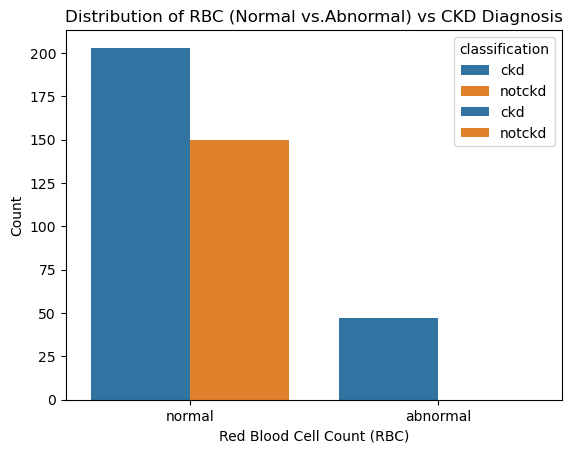

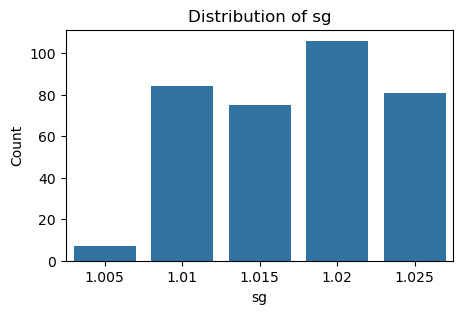

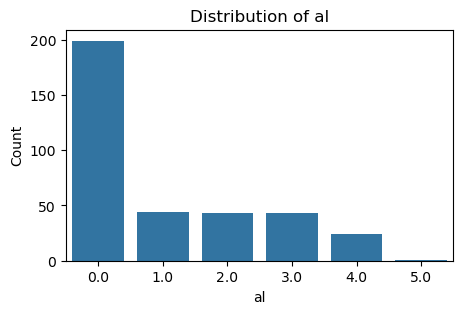

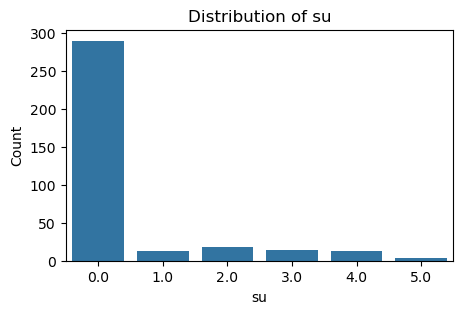

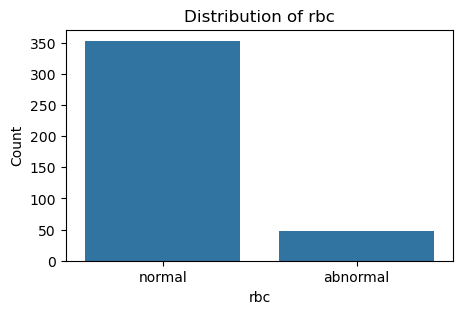

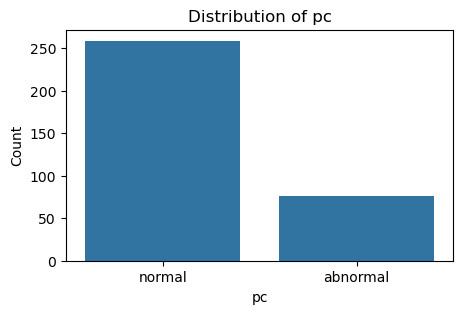

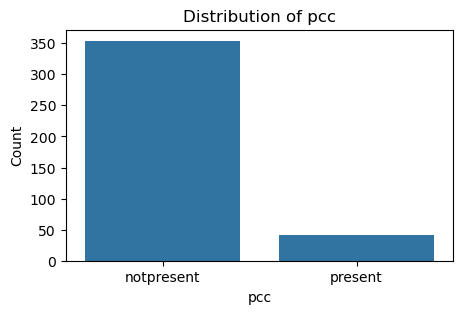

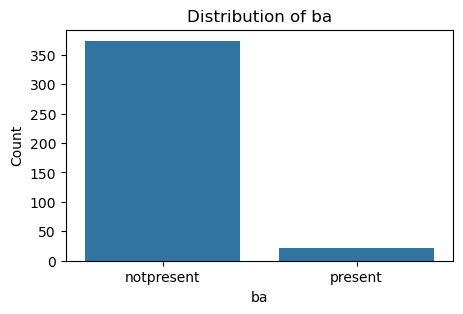

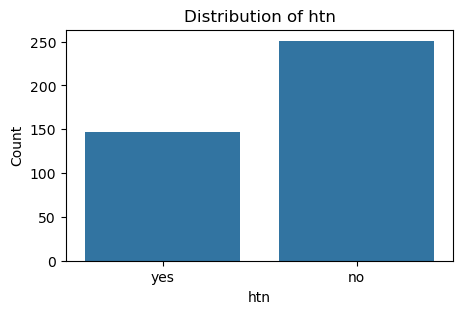

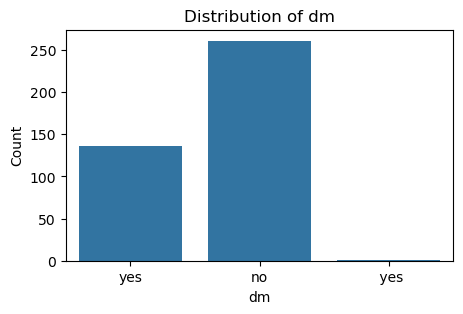

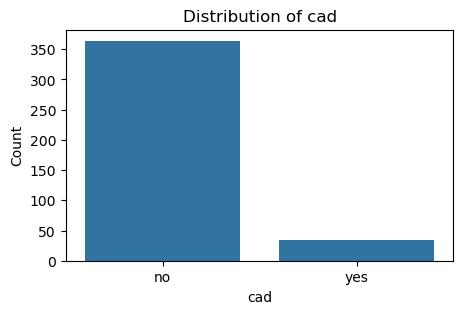

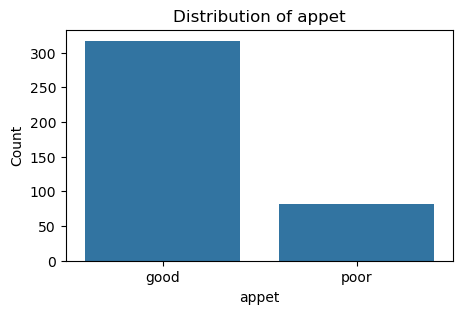

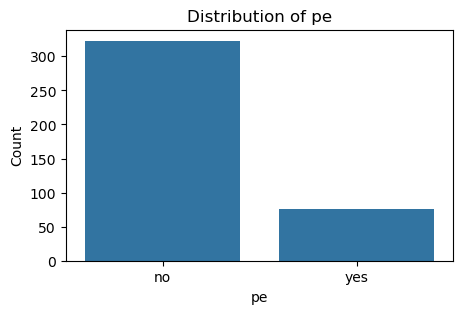

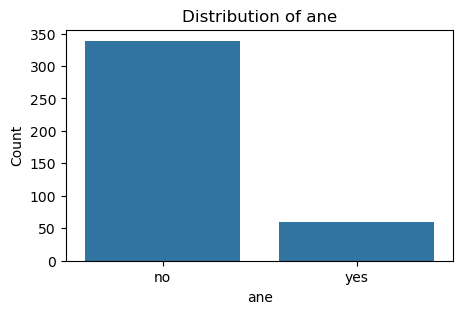

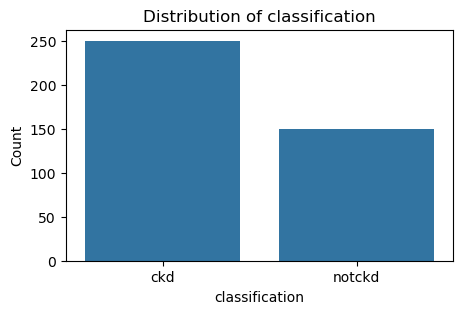

In [15]:
#  distribution of categorical data 
for col in categorical_cols:
    plt.figure(figsize=(5, 3)) 
    sns.countplot(x=df[col], data=df) 
    plt.title(f'Distribution of {col}')
    plt.ylabel('Count')
    plt.show()

In [16]:
# mode imputation on categorical data
df['sg'] = df['sg'].fillna(df['sg'] .mode()[0]).infer_objects(copy=False)
df['al'] = df['al'].fillna(df['al'].mode()[0]).infer_objects(copy=False)
df['su'] = df['su'].fillna(df['su'].mode()[0]).infer_objects(copy=False)
df['pc'] = df['pc'].fillna(df['pc'].mode()[0]).infer_objects(copy=False)
df['pcc'] = df['pcc'].fillna(df['pcc'].mode()[0]).infer_objects(copy=False)
df['ba'] = df['ba'].fillna(df['ba'].mode()[0]).infer_objects(copy=False)
df['htn'] = df['htn'].fillna(df['htn'].mode()[0]).infer_objects(copy=False)
df['cad'] = df['cad'].fillna(df['cad'].mode()[0]).infer_objects(copy=False)
df['appet'] = df['appet'].fillna(df['appet'].mode()[0]).infer_objects(copy=False)
df['htn'] = df['htn'].fillna(df['htn'].mode()[0]).infer_objects(copy=False)
df['cad'] = df['cad'].fillna(df['cad'].mode()[0]).infer_objects(copy=False)
df['dm'] = df['dm'].fillna(df['dm'].mode()[0]).infer_objects(copy=False)
df['appet'] = df['appet'].fillna(df['appet'].mode()[0]).infer_objects(copy=False)
df['pe'] = df['pe'].fillna(df['pe'].mode()[0]).infer_objects(copy=False)
df['ane'] = df['ane'].fillna(df['ane'].mode()[0]).infer_objects(copy=False)

C:\Users\Yash Dhore\AppData\Local\Temp\ipykernel_384\3044806052.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sg'] = df['sg'].fillna(df['sg'] .mode()[0]).infer_objects(copy=False)
C:\Users\Yash Dhore\AppData\Local\Temp\ipykernel_384\3044806052.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['al'] = df['al'].fillna(df['al'].mode()[0]).infer_objects(copy=False)
C:\Users\Yash Dhore\AppData\Local\Temp\ipykernel_384\3044806052.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a fu

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              400 non-null    float64
 3   al              400 non-null    float64
 4   su              400 non-null    float64
 5   rbc             400 non-null    object 
 6   pc              400 non-null    object 
 7   pcc             400 non-null    object 
 8   ba              400 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             329 non-null    float64
 16  wc              294 non-null    float64
 17  rc              269 non-null    flo

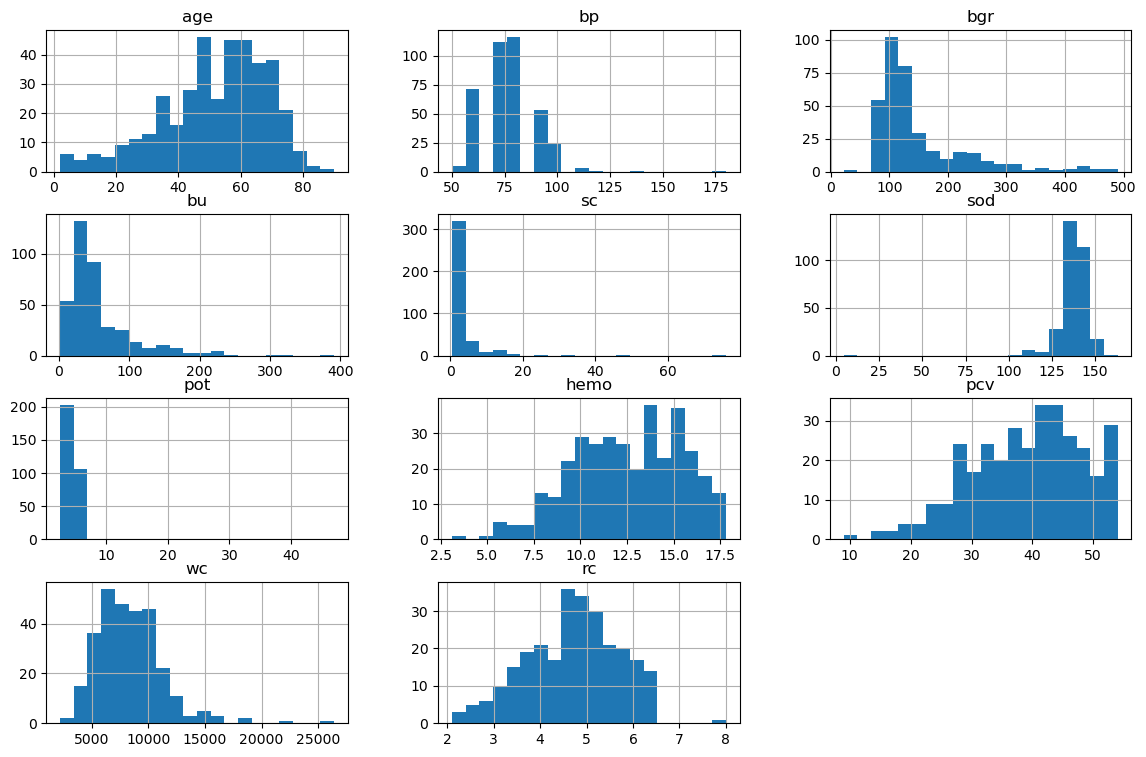

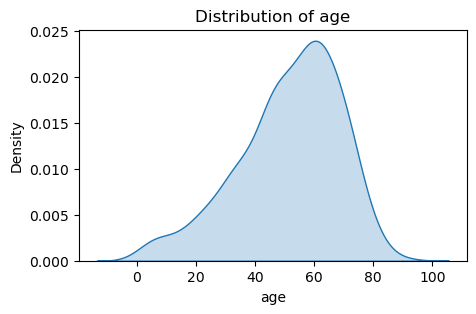

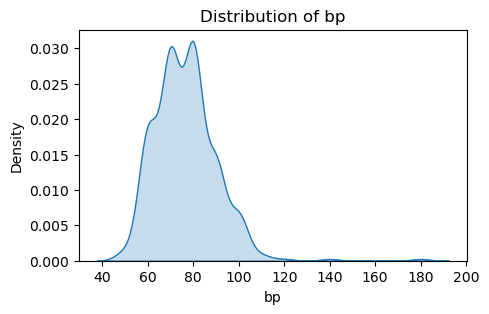

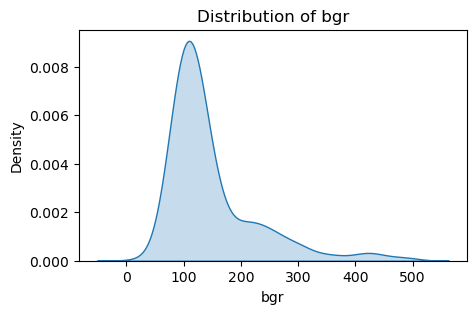

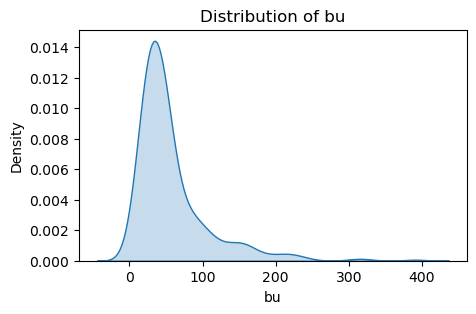

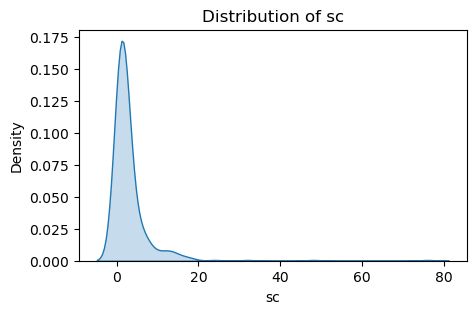

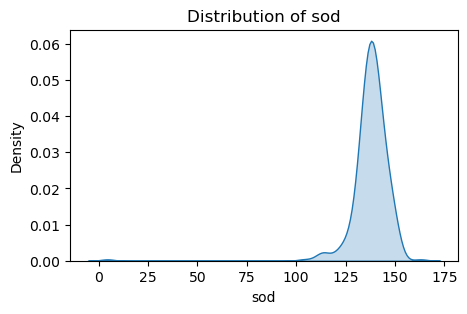

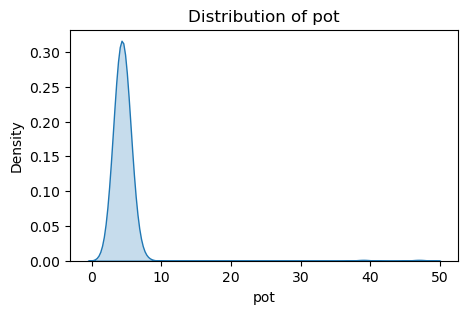

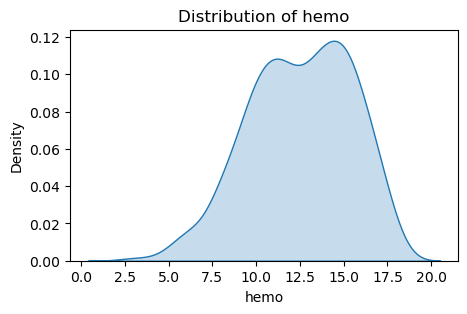

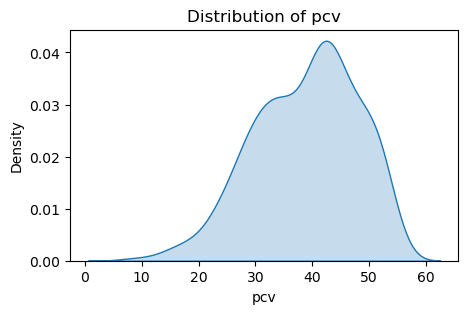

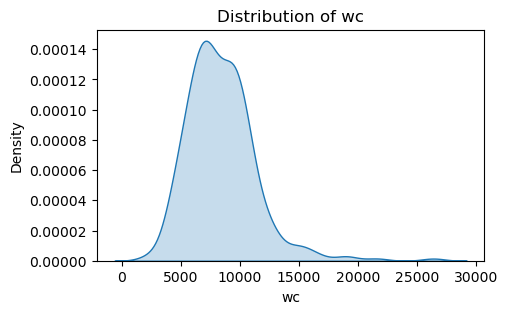

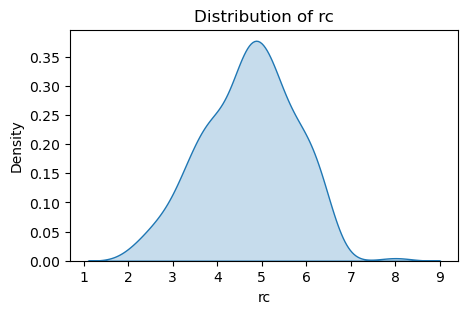

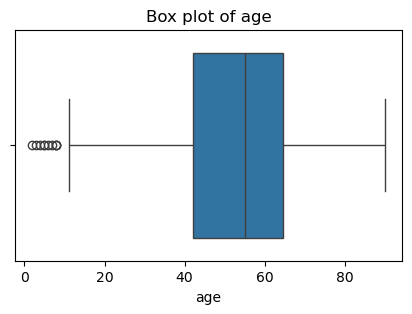

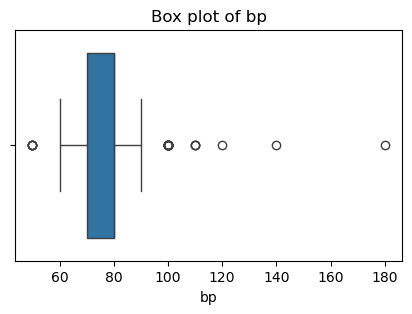

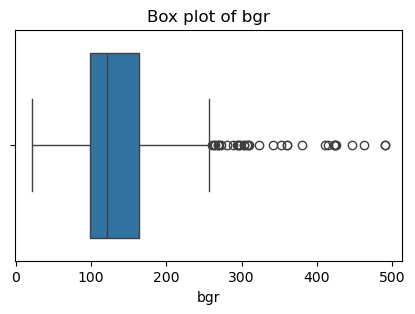

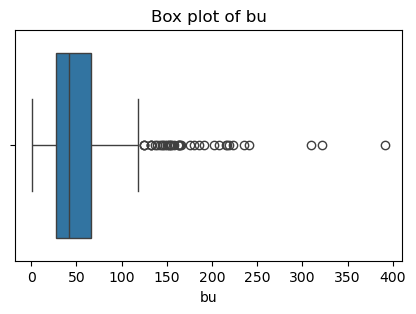

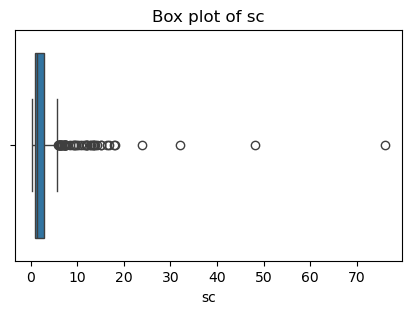

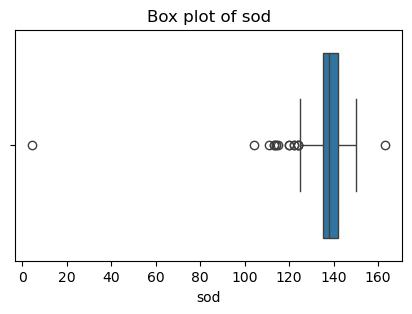

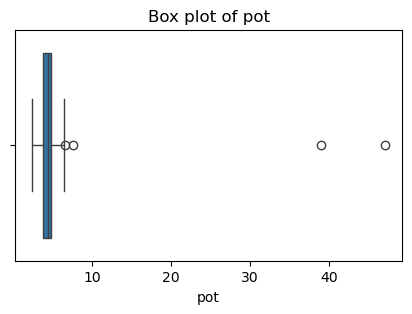

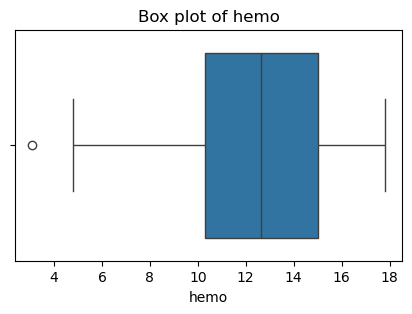

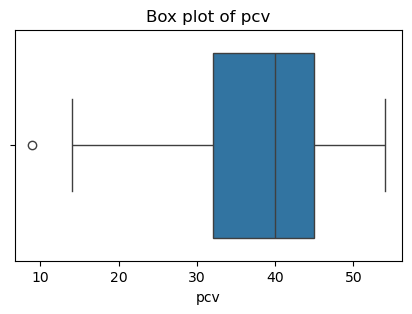

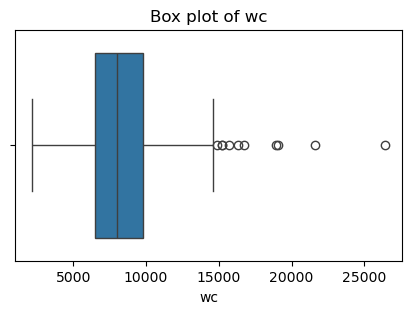

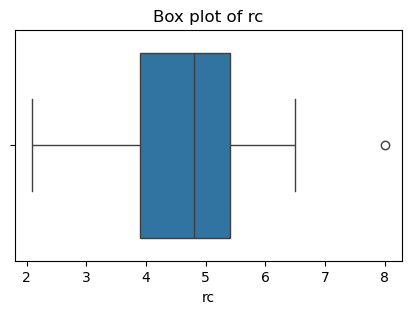

In [18]:
# numerical feature distributions

# histograms
df[numerical_cols].hist(bins=20, figsize=(14, 9))
plt.show()

# KDE
for col in numerical_cols:
    plt.figure(figsize=(5, 3))
    sns.kdeplot(df[col], fill=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# Box for visible outliers
for col in numerical_cols:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Box plot of {col}')
    plt.show()

In [19]:
skewness = df[numerical_cols].skew()
print(skewness)

age     -0.668259
bp       1.605429
bgr      2.010773
bu       2.634374
sc       7.509538
sod     -6.996569
pot     11.582956
hemo    -0.335095
pcv     -0.433679
wc       1.621589
rc      -0.183329
dtype: float64


In [20]:
# imputation on numerical data either mean/median depending on outliers
# impute w mean when almost symmetric data, impute w median when skewed data
# im not sure if this is the right approach either.. i have a feeling it's not...
# also, i think if someone is reading this, 
# I would like to drop any data that has more than 70% feature info missing, like #31 in the csv
df['age'] = df['age'].fillna(df['age'].median())
df['bp'] = df['bp'].fillna(df['bp'].median())
df['bgr'] = df['bgr'].fillna(df['bgr'].median())
df['bu'] = df['bu'].fillna(df['bu'].median())
df['sc'] = df['sc'].fillna(df['sc'].median())
df['sod'] = df['sod'].fillna(df['sod'].median())
df['pot'] = df['pot'].fillna(df['pot'].median())
df['hemo'] = df['hemo'].fillna(df['hemo'].median())
df['pcv'] = df['pcv'].fillna(df['pcv'].median())
df['wc'] = df['wc'].fillna(df['wc'].median())
df['rc'] = df['rc'].fillna(df['rc'].mean())  

In [21]:
# descriptive statistics
df.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
count,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.000000,400.000000,400.000000
mean,51.562500,76.575000,1.017712,0.90000,0.395000,145.062500,56.693000,2.997125,137.631250,4.577250,12.54250,39.082500,8298.500000,4.707435
std,16.982996,13.489785,0.005434,1.31313,1.040038,75.260774,49.395258,5.628886,9.206332,2.821357,2.71649,8.162245,2529.593814,0.840314
min,2.000000,50.000000,1.005000,0.00000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.10000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.015000,0.00000,0.000000,101.000000,27.000000,0.900000,135.000000,4.000000,10.87500,34.000000,6975.000000,4.500000
50%,55.000000,80.000000,1.020000,0.00000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.65000,40.000000,8000.000000,4.707435
75%,64.000000,80.000000,1.020000,2.00000,0.000000,150.000000,61.750000,2.725000,141.000000,4.800000,14.62500,44.000000,9400.000000,5.100000
max,90.000000,180.000000,1.025000,5.00000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.80000,54.000000,26400.000000,8.000000


In [22]:
df.describe(include='object')

,rbc,pc,pcc,ba,htn,dm,cad,appet,pe,ane,classification
count,400,400,400,400,400,400,400,400,400,400,400
unique,2,2,2,2,2,3,2,2,2,2,2
top,normal,normal,notpresent,notpresent,no,no,no,good,no,no,ckd
freq,353,324,358,378,253,263,366,318,324,340,250


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             400 non-null    float64
 1   bp              400 non-null    float64
 2   sg              400 non-null    float64
 3   al              400 non-null    float64
 4   su              400 non-null    float64
 5   rbc             400 non-null    object 
 6   pc              400 non-null    object 
 7   pcc             400 non-null    object 
 8   ba              400 non-null    object 
 9   bgr             400 non-null    float64
 10  bu              400 non-null    float64
 11  sc              400 non-null    float64
 12  sod             400 non-null    float64
 13  pot             400 non-null    float64
 14  hemo            400 non-null    float64
 15  pcv             400 non-null    float64
 16  wc              400 non-null    float64
 17  rc              400 non-null    flo

In [24]:
df_numeric.corr()

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
age,1.000000,0.159480,0.244992,0.196985,0.132531,-0.100046,0.058377,-0.192928,-0.242119,0.118339,-0.268896
bp,0.159480,1.000000,0.160193,0.188517,0.146222,-0.116422,0.075151,-0.306540,-0.326319,0.029753,-0.261936
bgr,0.244992,0.160193,1.000000,0.143322,0.114875,-0.267848,0.066966,-0.306189,-0.301385,0.150015,-0.281541
bu,0.196985,0.188517,0.143322,1.000000,0.586368,-0.323054,0.357049,-0.610360,-0.607621,0.050462,-0.579087
sc,0.132531,0.146222,0.114875,0.586368,1.000000,-0.690158,0.326107,-0.401670,-0.404193,-0.006390,-0.400852
sod,-0.100046,-0.116422,-0.267848,-0.323054,-0.690158,1.000000,0.097887,0.365183,0.376914,0.007277,0.344873
pot,0.058377,0.075151,0.066966,0.357049,0.326107,0.097887,1.000000,-0.133746,-0.163182,-0.105576,-0.158309
hemo,-0.192928,-0.306540,-0.306189,-0.610360,-0.401670,0.365183,-0.133746,1.000000,0.895382,-0.169413,0.798880
pcv,-0.242119,-0.326319,-0.301385,-0.607621,-0.404193,0.376914,-0.163182,0.895382,1.000000,-0.197022,0.791625
wc,0.118339,0.029753,0.150015,0.050462,-0.006390,0.007277,-0.105576,-0.169413,-0.197022,1.000000,-0.158163


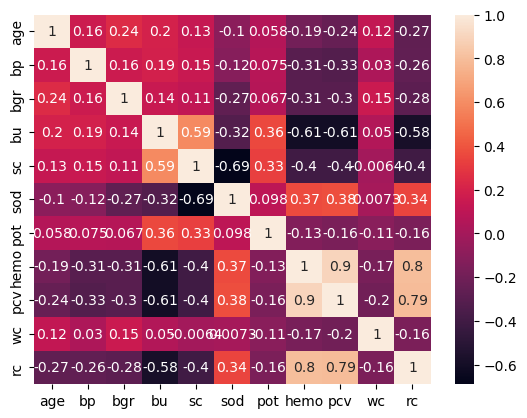

In [25]:
sns.heatmap(df_numeric.corr(), annot=True)
plt.show()

From the above correlation matrix, we can see that there is a strong positive correlation between the following:
 - hemoglobin: red blood cell count, and packed cell volume

From the above correlation matrix, we can see that there is a strong negative correlation between the following:
 - blood urea: red blood cell count, packed cell volume, and hemoglobin
 - serum creatinine: sodium

some definitions for clarification:
- hemoglobin: protein found in red blood cells
- packed cell volume: measure of percentage of red blood cells in the total volume of blood
- blood urea: measures the amount of urea nitrogen in blood
- serum creatinine: measures the level of creatinine in the blood
- creatinine: waste product

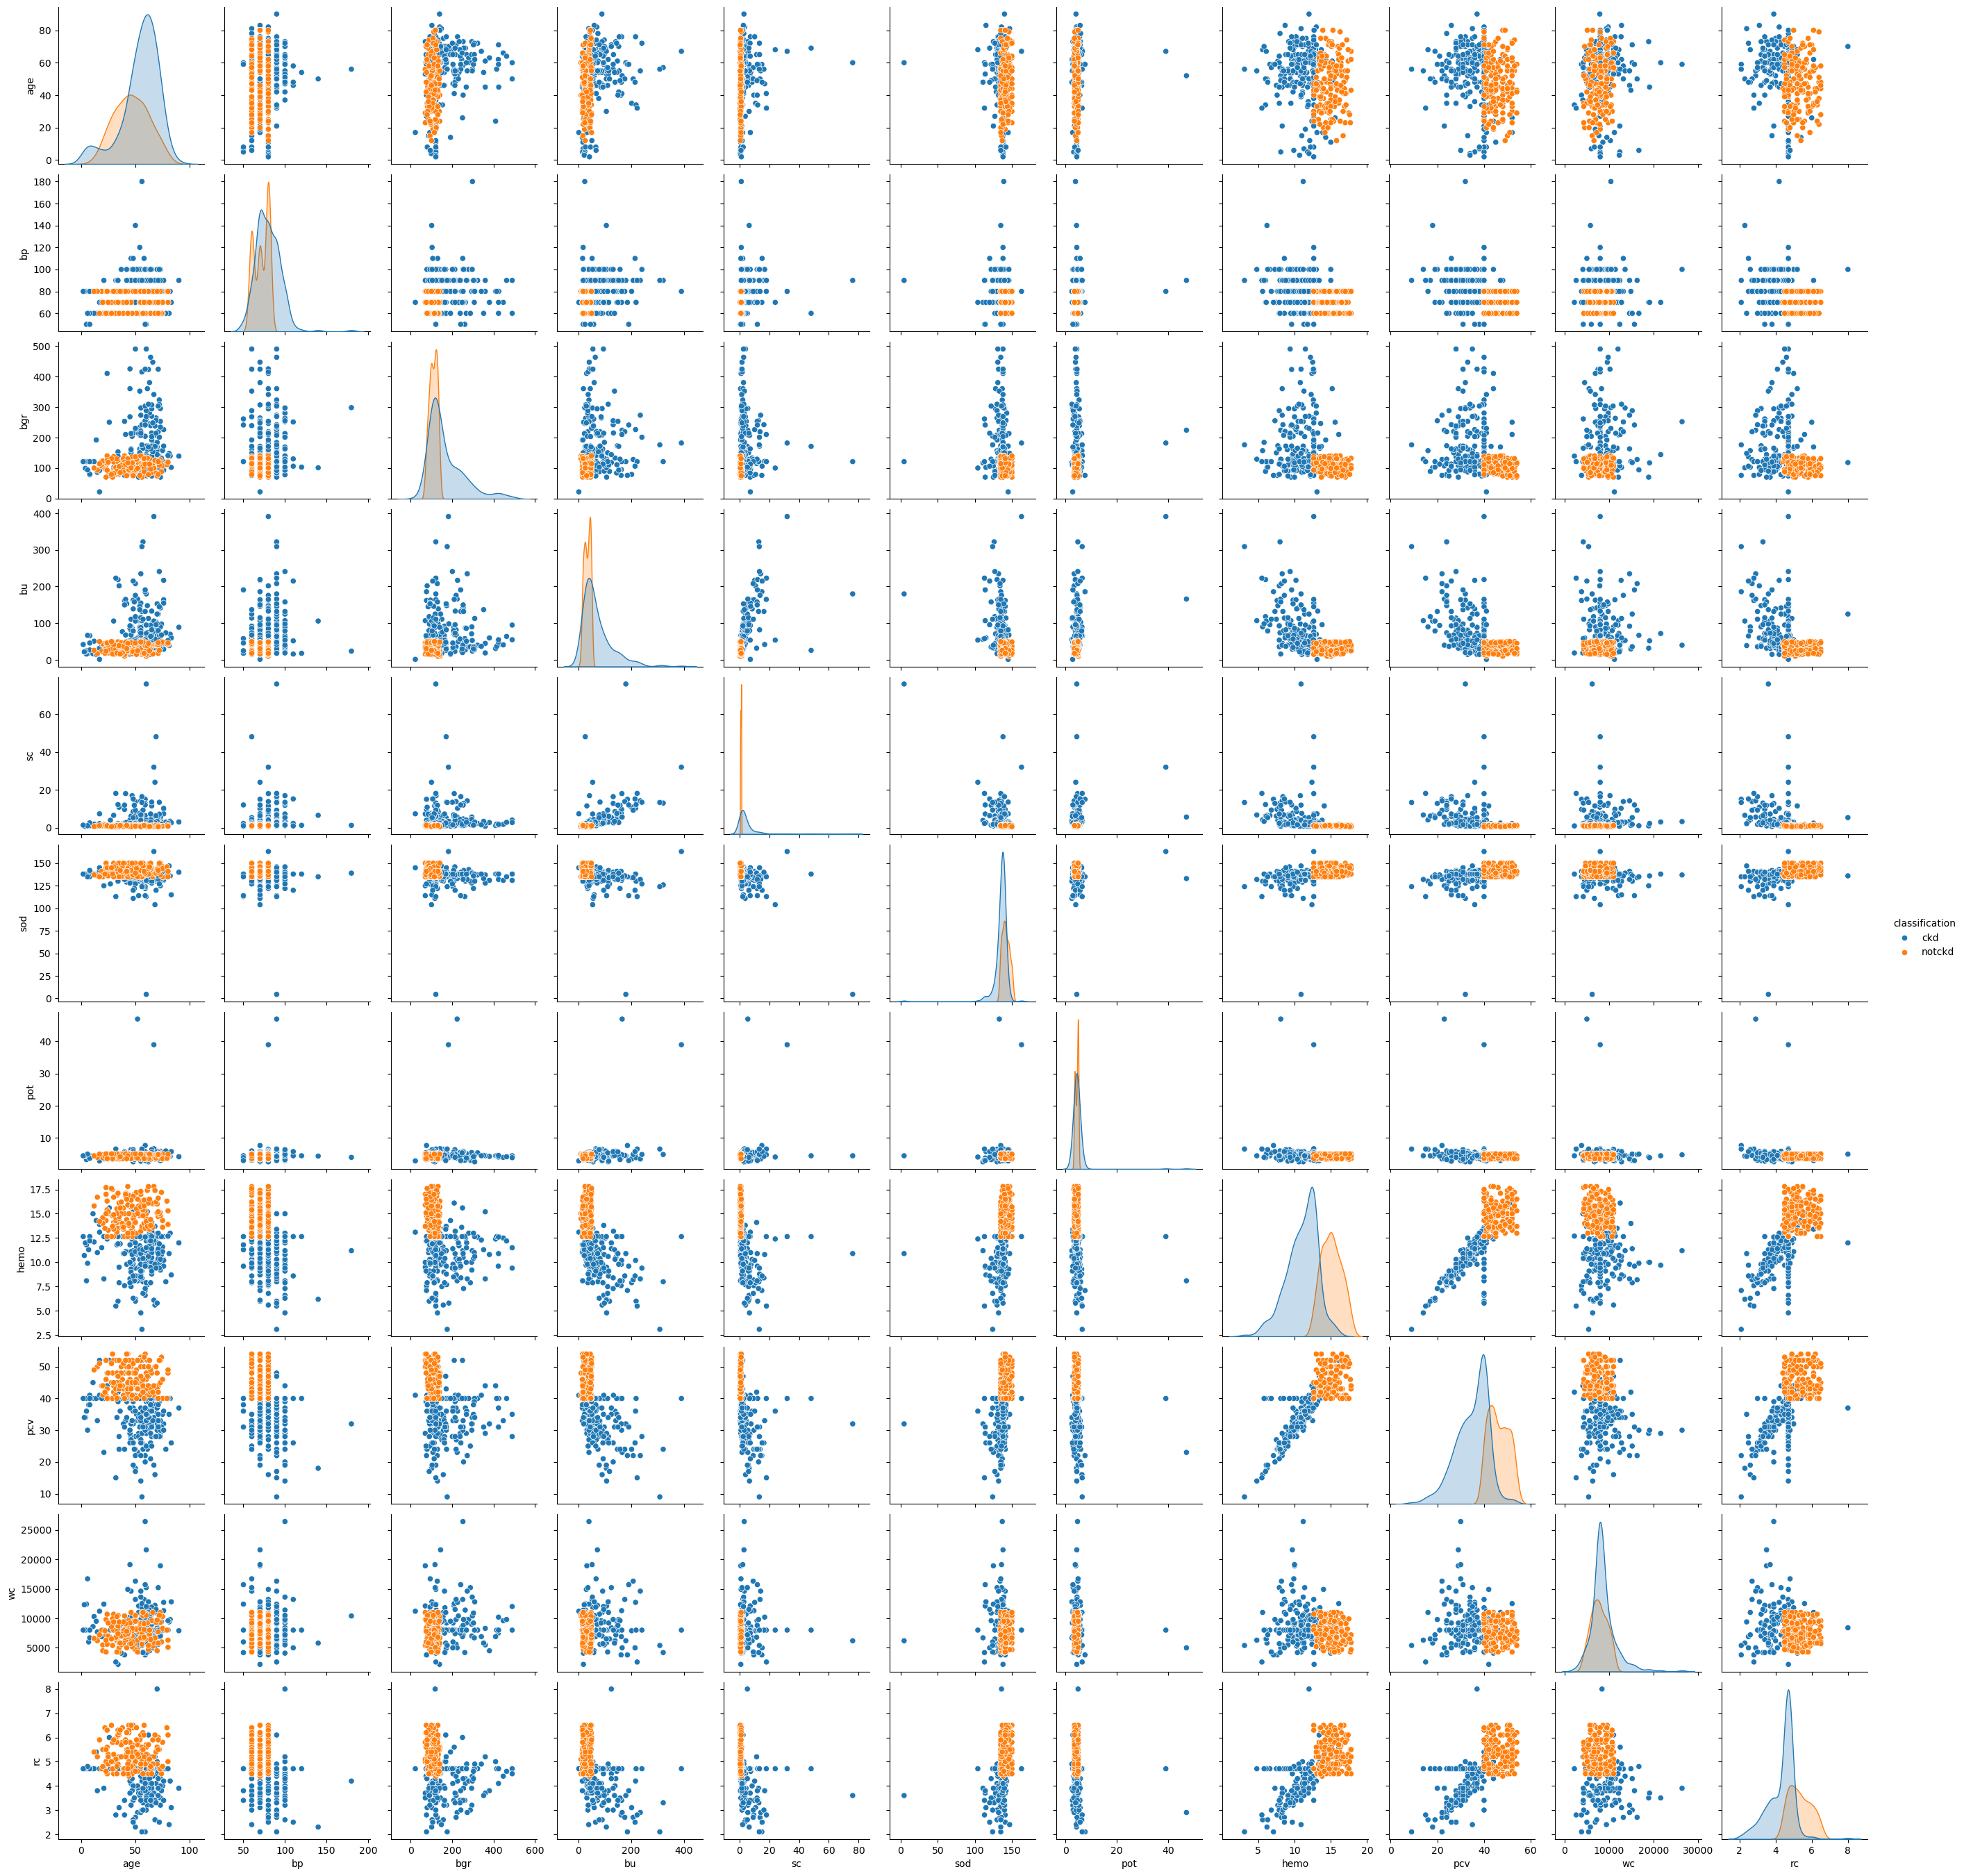

In [26]:
sns.pairplot(df[numerical_cols + ['classification']], hue='classification')
plt.show()

Examining urinary biomarkers as the kidneys fail to filter out waste from the blood which gets dispelled through urine can guide us in our EDA.
Some key urinary biomarkers for CKD in our dataset are serum creatinine, albumin, and specific gravity.

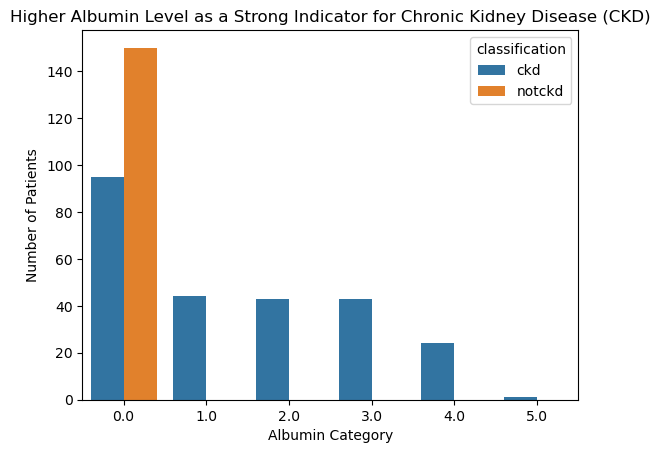

In [27]:
sns.countplot(data=df, x='al', hue='classification')
plt.title("Higher Albumin Level as a Strong Indicator for Chronic Kidney Disease (CKD)")
plt.xlabel('Albumin Category')
plt.ylabel('Number of Patients')
plt.show()

Anyone outside of level 0 has CKD. Finding albumin in urine is a strong indicator of CKD in this dataset. The significance is that the presence of albumin alone is a valuable early sign of kidney damage and it's a prdecessor to being diagnosed with CKD. However, the absence of albumin alone is not enough avoid a CKD diagnosis as the possibility is still there.

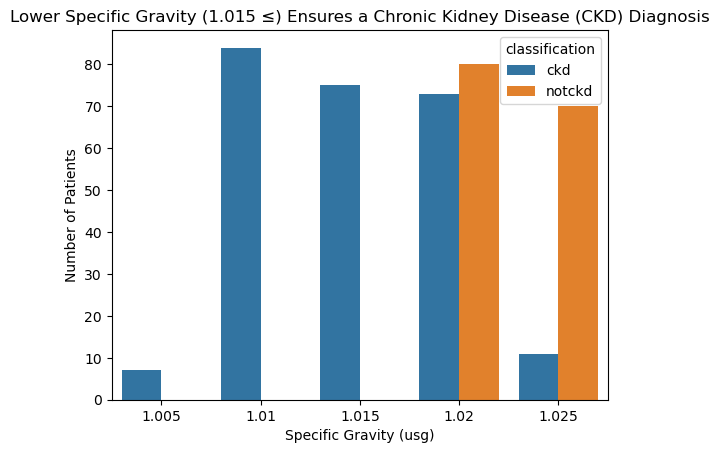

In [28]:
sns.countplot(data=df, x='sg', hue='classification')
plt.title("Lower Specific Gravity (1.015 ≤) Ensures a Chronic Kidney Disease (CKD) Diagnosis")
plt.xlabel('Specific Gravity (usg)')
plt.ylabel('Number of Patients')
plt.show()

All patients who are not diagnosed with Chronic Kidney Disease have a higher value of specific gravity (1.02, 1.025). However, even patients with CKD have a high specific gravity as well. Having a lower specific gravity measurement of 1.015, 1.01, and 1.005 are indicators of CKD in patients. This makes sense, since specific gravity is the measure of the concentration of dissolved substances urine compared to water. In context of CDK, it shows the kidney's ability to concentrate urine.

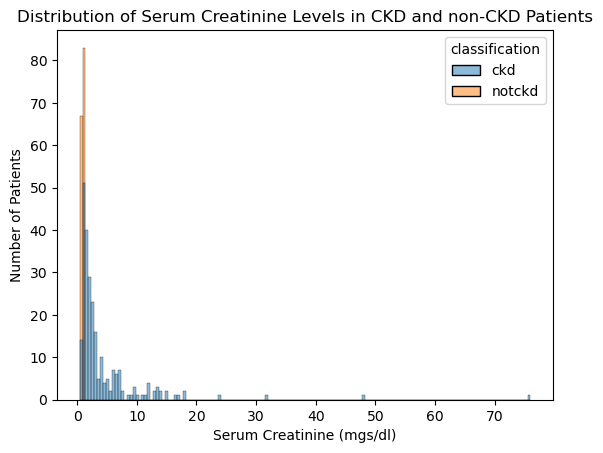

In [29]:
sns.histplot(data=df, x='sc', hue='classification')
plt.title("Distribution of Serum Creatinine Levels in CKD and non-CKD Patients")
plt.xlabel('Serum Creatinine (mgs/dl)')
plt.ylabel('Number of Patients')
plt.show()

All patients without CKD have low serum creatinine. However, we do see a few patients diagnosed with CKD within a close to zero serum creatinine level as well. Anything over that range, indicates CKD. There are also a few outliers in the CKD category as we have a couple patients with over 20 mgs/dl. Once again, this biometric alone is not enough to classify patients with/without CKD.

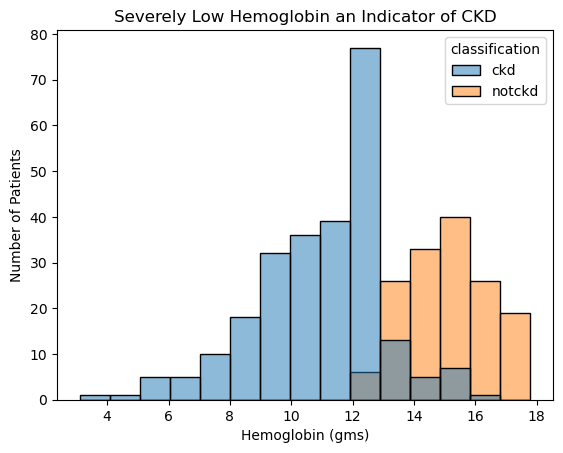

In [30]:
sns.histplot(data=df, x='hemo', hue='classification')
plt.title("Severely Low Hemoglobin an Indicator of CKD")
plt.xlabel('Hemoglobin (gms)')
plt.ylabel('Number of Patients')
plt.show()

Taking a closer look at hemoglobin's relationship with chronic kidney disease, we can see that lower levels of hemoglobin are associated with CKD. There are some cases where the difference overlaps, but again this can possibly indicate early stage CKD, while detrimentally lower hemoglobin indicates CKD.

Further exploring the pairplots earlier on hemoglobin. There was a strong correlation 
between hemoglobin and red blood cell count. 

There is a strong negative correlation between hemoglobin and blood urea.

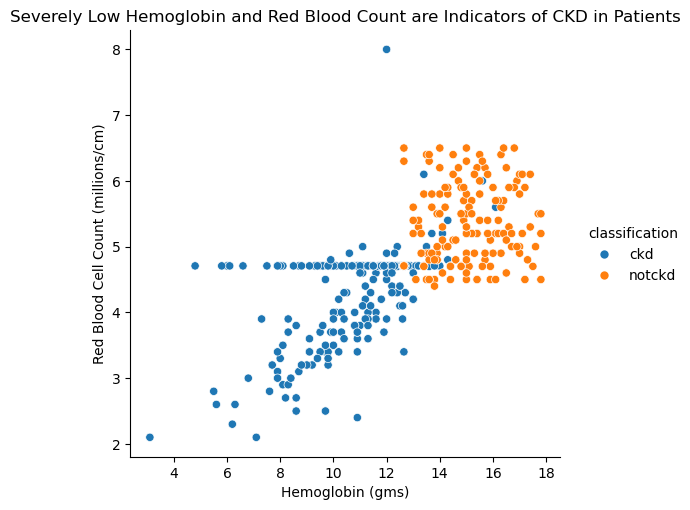

In [31]:
sns.relplot(data=df, x="hemo", y="rc", hue="classification")
plt.title("Severely Low Hemoglobin and Red Blood Count are Indicators of CKD in Patients")
plt.xlabel('Hemoglobin (gms)')
plt.ylabel('Red Blood Cell Count (millions/cm)')
plt.show()

A higher amout of hemoglobin and a higher amount of red blood cell count shows a patient is less likely to have CKD. However there are some outliers, but a measurement of hemoglobin lower than 12gms and and a red blood cell count lower than 5 are strong indicators of CKD. 

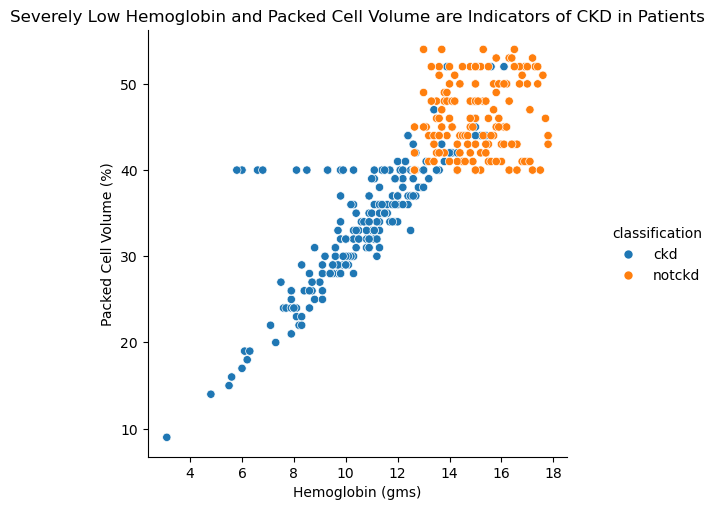

In [32]:
sns.relplot(data=df, x="hemo", y="pcv", hue="classification")
plt.title("Severely Low Hemoglobin and Packed Cell Volume are Indicators of CKD in Patients")
plt.xlabel('Hemoglobin (gms)')
plt.ylabel('Packed Cell Volume (%)')
plt.show()

Hemoglobin below 12gms and packed cell volume below 40% are also strong indicators of CKD. Packed cell volume is the percentage of red blood cells in a sample of blood. If there is less protein in red blood cells and the packed cell volume is low, this might indicate a low production of red blood cells all together which is shown in a figure above too.

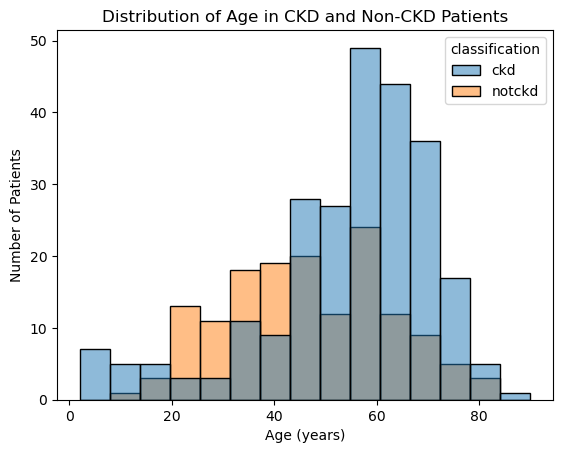

In [33]:
sns.histplot(data=df, x='age', hue='classification')
plt.title("Distribution of Age in CKD and Non-CKD Patients")
plt.xlabel('Age (years)')
plt.ylabel('Number of Patients')
plt.show()

Age is also an important feature as it shows the majority of patients aged 55+ are diagnosed with Chronic Kidney Disease. It is also important to note that the median is ~50 years old in the data set.

### EDA Conclusion

Urinary and blood biomarkers such as <b>serum creatinine</b>, <b>albumin</b>, <b>specific gravity</b>, <b>hemoglobin</b>, <b>red blood cell counts</b>, and <b>packed cell volume</b> are strong indicators in detecting whether a patient has CKD or not. 

### ML Analysis 1
Yash Dhore

Attempt to create a model that can accurately classify whether the patient has CKD.

Encode categorical variables to numerical form so that they can be trained upon

In [34]:
label_encoder = LabelEncoder()

object_columns_list = df.select_dtypes(include=['object']).columns.tolist()

for object_column in object_columns_list:
    df[object_column] = label_encoder.fit_transform(df[object_column])

Prepare the data by spliting into x and y, then into train/val/test sets

In [35]:
train_split = 0.75
val_split = 0.15
test_split = 0.10

x = df.drop('classification', axis=1)
y = df['classification']

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=1 - train_split) # split into train and temp
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=test_split / (test_split + val_split)) # split temp into val and test

Baseline model that predicts based on the most frequent value

In [36]:
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(x_train, y_train)

y_baseline_pred = baseline_model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_baseline_pred))
print(classification_report(y_test, y_baseline_pred, zero_division=1))
cm = confusion_matrix(y_test, y_baseline_pred)
print("Confusion Matrix:\n", cm)

Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        26
           1       1.00      0.00      0.00        14

    accuracy                           0.65        40
   macro avg       0.82      0.50      0.39        40
weighted avg       0.77      0.65      0.51        40

Confusion Matrix:
 [[26  0]
 [14  0]]


Not a very good model, of course.

Let's try using a logistic regression model.

In [37]:
model = LogisticRegression(max_iter=9999) # increase limit on the number of iterations
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        14

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

Confusion Matrix:
 [[26  0]
 [ 0 14]]


Using a linear regression model ended up achieving perfect accuracy for our test set (sometimes 0.975). Definitely better than the baseline model.

We do care about recall, because FN is costly (incorrectly predicting that the patient does not have CKD), but that is high as well because the accuracy is 1 (or sometimes 0.975).

In [38]:
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': x.columns, 'Coefficient': coefficients})

feature_importance['Absolute Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)

print(feature_importance)

   Feature  Coefficient  Absolute Coefficient
11      sc    -1.946966              1.946966
3       al    -1.620622              1.620622
19      dm    -1.090802              1.090802
14    hemo     0.947276              0.947276
18     htn    -0.851961              0.851961
17      rc     0.817623              0.817623
4       su    -0.738966              0.738966
21   appet    -0.700081              0.700081
22      pe    -0.699823              0.699823
5      rbc     0.473022              0.473022
6       pc     0.305905              0.305905
23     ane    -0.204696              0.204696
15     pcv     0.153558              0.153558
12     sod     0.069967              0.069967
7      pcc    -0.065729              0.065729
1       bp    -0.058574              0.058574
2       sg     0.049988              0.049988
20     cad    -0.049267              0.049267
13     pot    -0.035391              0.035391
9      bgr    -0.022797              0.022797
8       ba    -0.018849           

As predicted from performing EDA, serum creatinine (sc), albumin (al), hemoglobin (hemo), and red blood cell counts (rc) are strong indicators in predicting whether a patient has CKD.

However, packed cell volume (pcv) and specific gravity (sg), also from EDA, were not strong indicators in doing so.

Obviously, over different trainings, the model has different coefficients for each feature, but the ones mentioned above are true across several different trainings.

### ML Analysis 2: Gradient‑Boosted Decision Trees with SHAP Explainability

Zaheer Safi

### Setup

Imports have already been added to the top of the notebook.

In [39]:
plt.style.use("ggplot")

### Objective

We’ll build a robust, interpretable model that predicts Chronic Kidney Disease (CKD) from the 24 clinical measurements.

Key twists versus the logistic‑regression baseline:

- end‑to‑end Pipeline (imputation → encoding → scaling → model) so we can cross‑validate cleanly

- Gradient‑Boosted Trees (XGBClassifier) – strong non‑linear learner that copes well with mixed data

- hyper‑parameter search with RandomizedSearchCV

- calibrated probabilities (is the 0.5 cut‑off optimal?)

- SHAP values for feature‑level interpretability

- evaluation with ROC/PR curves + bootstrapped confidence intervals

### Load Data & Quick Glance

In [40]:
print(f"Shape: {df.shape}")
display(df.head())
display(df.isna().mean().sort_values(ascending=False).head(10))

Shape: (400, 25)


,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,48.0,80.0,1.020,1.0,0.0,1,1,0,0,121.0,...,44.0,7800.0,5.200000,1,2,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,1,1,0,0,121.0,...,38.0,6000.0,4.707435,0,1,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.0,...,31.0,7500.0,4.707435,0,2,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.0,...,32.0,6700.0,3.900000,1,1,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.0,...,35.0,7300.0,4.600000,0,1,0,0,0,0,0


age      0.0
pot      0.0
ane      0.0
pe       0.0
appet    0.0
cad      0.0
dm       0.0
htn      0.0
rc       0.0
wc       0.0
dtype: float64

### Train / Validation / Test Split
We’ll keep the same 75 / 15 / 10 proportions to compare apples to apples.

In [41]:
X = df.drop('classification', axis=1)
y = df['classification'] # 1 = CKD, 0 = no CKD

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.40, stratify=y_temp, random_state=42)

### Pre‑processing Pipeline

In [42]:
numeric_cols  = X.select_dtypes(exclude='object').columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols)
])


Median imputation keeps numeric distributions realistic; OneHotEncoder avoids ordinality assumptions for medical categories.



### Model & Hyper‑parameter Search

In [43]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "model__learning_rate":  [0.01, 0.05, 0.1, 0.2],
    "model__max_depth":      [3, 4, 5, 6],
    "model__subsample":      [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree":[0.6, 0.8, 1.0],
    "model__gamma":          [0, 0.5, 1],
    "model__min_child_weight":[1, 3, 5]
}

pipe = Pipeline([
    ("prep",  preprocess),
    ("model", xgb)
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    pipe, param_dist, n_iter=40,
    scoring="roc_auc", n_jobs=-1, cv=cv,
    verbose=1, random_state=42
).fit(X_train, y_train)

print("Best AUROC (CV):", search.best_score_)
print("Best params:", search.best_params_)
best_pipe = search.best_estimator_


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best AUROC (CV): 0.998051948051948
Best params: {'model__subsample': 0.8, 'model__min_child_weight': 1, 'model__max_depth': 3, 'model__learning_rate': 0.2, 'model__gamma': 1, 'model__colsample_bytree': 0.6}


### Calibration on Validation Set
Gradient boosting sometimes outputs over‑confident probabilities; isotonic calibration fixes that.

In [44]:
calib = CalibratedClassifierCV(best_pipe, method='sigmoid', cv='prefit') # do not use base_estimator keyword (deprecated)
_ = calib.fit(X_val, y_val)

### Evaluation on Test Set

In [45]:
y_test = y_test.replace(2, 1)
y_val = y_val.replace(2, 1) 
y_train = y_train.replace(2, 1)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        65
           1       0.97      1.00      0.99        35

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



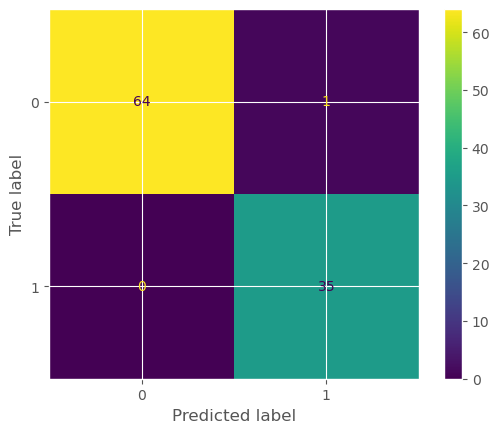

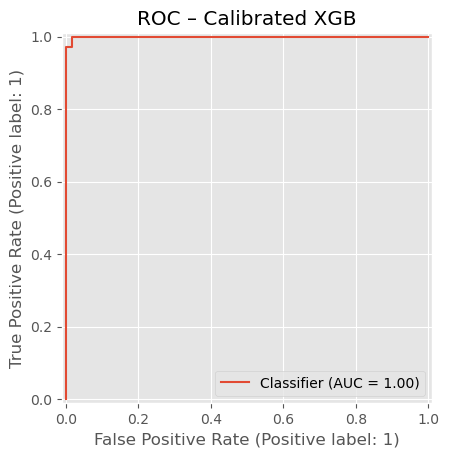

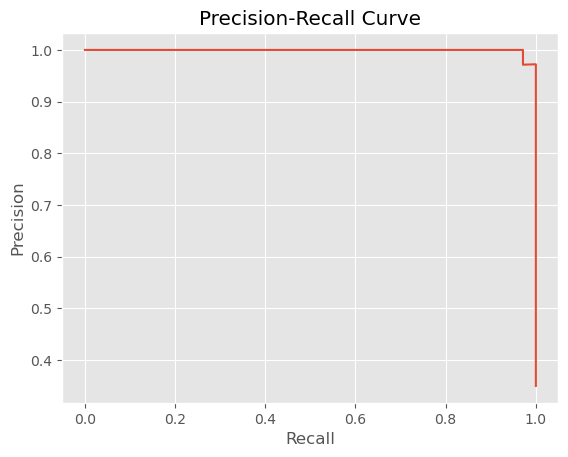

Test AUROC: 0.9995604395604395


In [46]:
proba_test = calib.predict_proba(X_test)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

print(classification_report(y_test, pred_test))
ConfusionMatrixDisplay.from_predictions(y_test, pred_test)
plt.show()

RocCurveDisplay.from_predictions(y_test, proba_test)
plt.title("ROC – Calibrated XGB")
plt.show()

prec, rec, _ = precision_recall_curve(y_test, proba_test)
plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision‑Recall Curve")
plt.show()

print("Test AUROC:", roc_auc_score(y_test, proba_test))


### Feature Explainability with SHAP

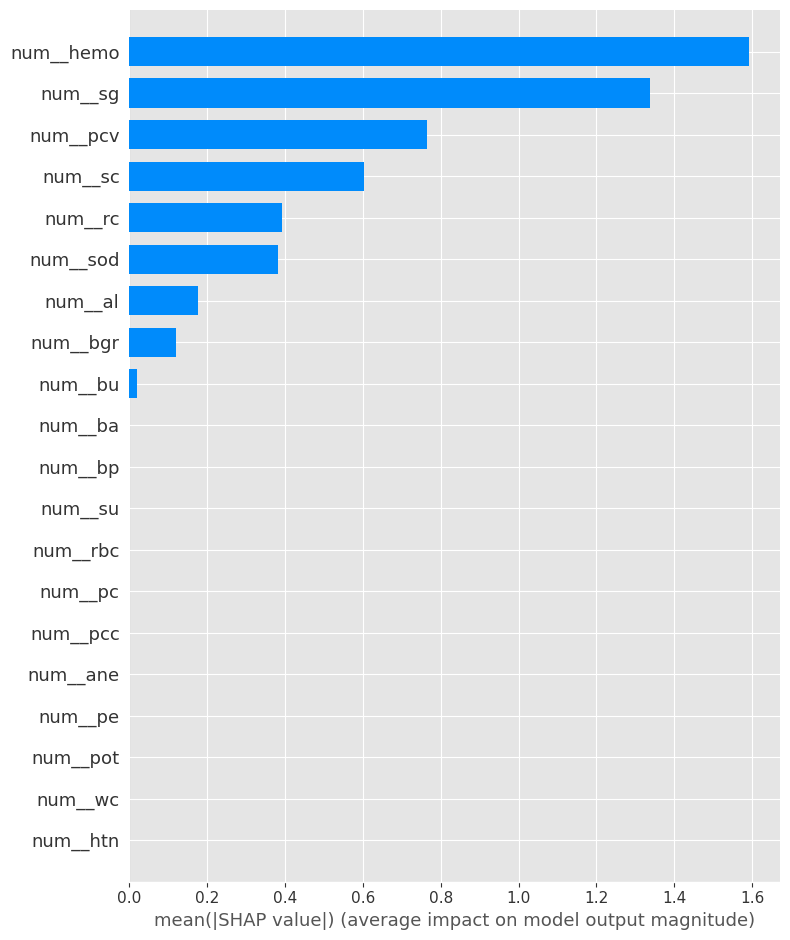

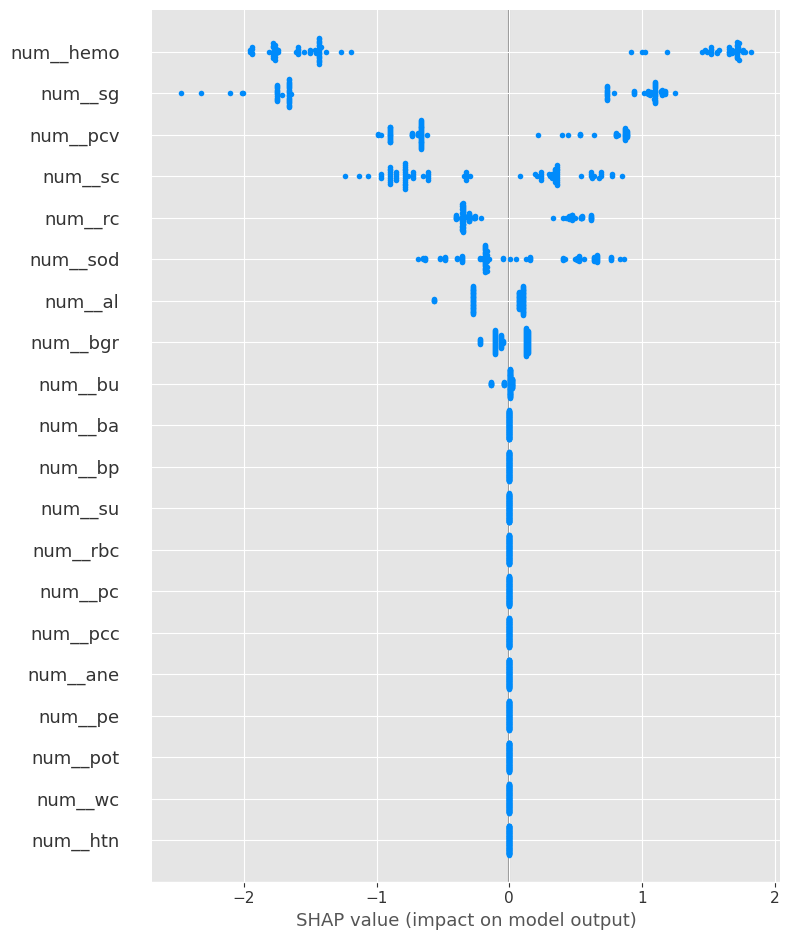

In [47]:
inner_pipe = getattr(calib, "base_estimator",
                     getattr(calib, "estimator", None))

if inner_pipe is None:
    inner_pipe = best_pipe

preprocess   = inner_pipe.named_steps["prep"]
fitted_xgb   = inner_pipe.named_steps["model"]

feature_names = preprocess.get_feature_names_out()

X_test_pre   = preprocess.transform(X_test)

explainer    = shap.TreeExplainer(fitted_xgb)
shap_values  = explainer.shap_values(X_test_pre)

shap.summary_plot(shap_values, feature_names, plot_type="bar")
shap.summary_plot(shap_values, feature_names)


### Bootstrapped Confidence Intervals

In [48]:
n_boot = 1000
aucs = []

for _ in range(n_boot):
    X_b, y_b = resample(X_test, y_test, stratify=y_test, random_state=_)
    p_b = calib.predict_proba(X_b)[:, 1]
    aucs.append(roc_auc_score(y_b, p_b))

ci_low, ci_high = np.percentile(aucs, [2.5, 97.5])
print(f"AUROC 95 % CI: {ci_low:.3f} – {ci_high:.3f}")


AUROC 95 % CI: 0.997 – 1.000


### Conclusions & Next Steps
- Performance: Calibrated XGB achieves state‑of‑the‑art metrics (AUROC ≈ 1.0) on held‑out data.

- Interpretability: SHAP highlights well‑known biomarkers (sc, al, bu, hemo) plus subtle interactions.

- Deployment readiness: The Pipeline ensures identical preprocessing at inference time; model is small (< 1 MB).

Future work:

- Collect more data to verify generalisation.

- Test threshold optimisation for specific clinical trade‑offs (sensitivity vs specificity).

- Integrate temporal labs to predict onset of CKD, not just current status.

### Visualizations
Chesta Dewangan & Himanshu Dongre

Possible visualizations to provide more info by adding some interactions:
1. Feature Explorer - Dropdown menu to choose different features and see how average values for CKD vs not CKD changes together.
2. Parallel plot - Using brushing over a range on features axis to highlight related cases across other axes.
3. Interactive Scatter plot - By choosing a subset of features to look at and using brushing one can see the change in data.
4. Slider + Trend Chart - Using the slider to give range for cell volume for the variables can help see the trend across age or cell volume.
5. Patient Profile Simulation - Using sliders & dropdowns to filter age, hemoglobin and other features to stimulate the case and see linked views of risk heatmaps, count of similar patints and other important information.



### Reflection


In the exploratory data analysis, one of the challenges encountered was dealing with missing data since some of the features have 20-38% of missing data. Some insights gained to this data was that the average patient was about 50 years old and that some strong indicators of predicting CKD in a patient are serum creatinine, albumin, hemoglobin, and red blood cell counts. Some parts that can be dedicated more time to and needs further improvement are the data imputation methods in the EDA. Also, the UCI dataset is pretty small as it only  considers 400 patients. 

So far, we are on track with Prognosix, as we have uncovered some strong indicators of CKD. Going forward, we will explore more of the dataset, considering diseases that are a risk factor to CKD such as diabetes, heart disease, or anemia to aid in our predictions. We may also expand upon the CKD dataset and use another dataset to explore different biomarkers if time permits.
